In [1]:
import lib.draw as draw
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import json
import glob
from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import torch
import optuna

In [2]:
all_files = glob.glob('data/json/*.json')

In [3]:
all_games = []
for f in tqdm(all_files):
    all_games.append(json.load(open(f)))

100%|██████████| 306/306 [00:16<00:00, 18.11it/s]


In [4]:
def calculate_xg_map(all_shots, all_goals, k=30):
    data = [i + [0] for i in all_shots] + [i + [1] for i in all_goals]
    data = pd.DataFrame(data, columns=['x','y','isGoal'])

    nn = NearestNeighbors(n_neighbors=k, n_jobs = -1)
    nn.fit(data[['x','y']], data['isGoal'])

    xgmap = [[i,j] for i in range(50,100) for j in np.arange(0, 100, 1.5)]
    xgmap = pd.DataFrame(xgmap, columns=['x','y'])

    estimated_xg = []
    for i, pixel in xgmap.iterrows():
        neighbors_dist, neighbors_ind = nn.kneighbors(pixel[['x','y']].to_numpy().reshape(1, -1))
        counter = 0
        sumer = 0
        for n_dist, n_ind in zip(neighbors_dist[0], neighbors_ind[0]):
            if n_dist > 10:
                continue
            counter += 1
            sumer += data.loc[n_ind]['isGoal']
        # Avoid div by 0
        if counter == 0:
            counter += 1

        estimated_xg.append(sumer / counter)

    xgmap['xg'] = estimated_xg

    return xgmap

In [5]:
def plot_xg_map(xgmap):
    draw.pitch()
    cmap = np.zeros((len(xgmap),4))
    cmap[:,0] = 1; cmap[:,1] = 1; cmap[:,2] = 1; cmap[:,3] = xgmap.xg
    plt.scatter(xgmap.x, xgmap.y, s = 15, c = cmap, marker = 's', linewidth=0, zorder = 10);

draw.pitch()
all_shots = []
all_goals = []
for game in all_games:
    for event in game['events']:
        if 'isShot' in event.keys() and 'isGoal' not in event.keys():
            all_shots.append([event['x'], event['y']])
        if 'isGoal' in event.keys() and 'isOwnGoal' not in event.keys():
            all_goals.append([event['x'], event['y']])
plt.scatter(*zip(*all_shots), s=5, color = '#5b1289', zorder = 5);
plt.scatter(*zip(*all_goals), s=5, color = '#ab3b00', zorder = 5);

xgmap = calculate_xg_map(all_shots, all_goals)
plot_xg_map(xgmap)

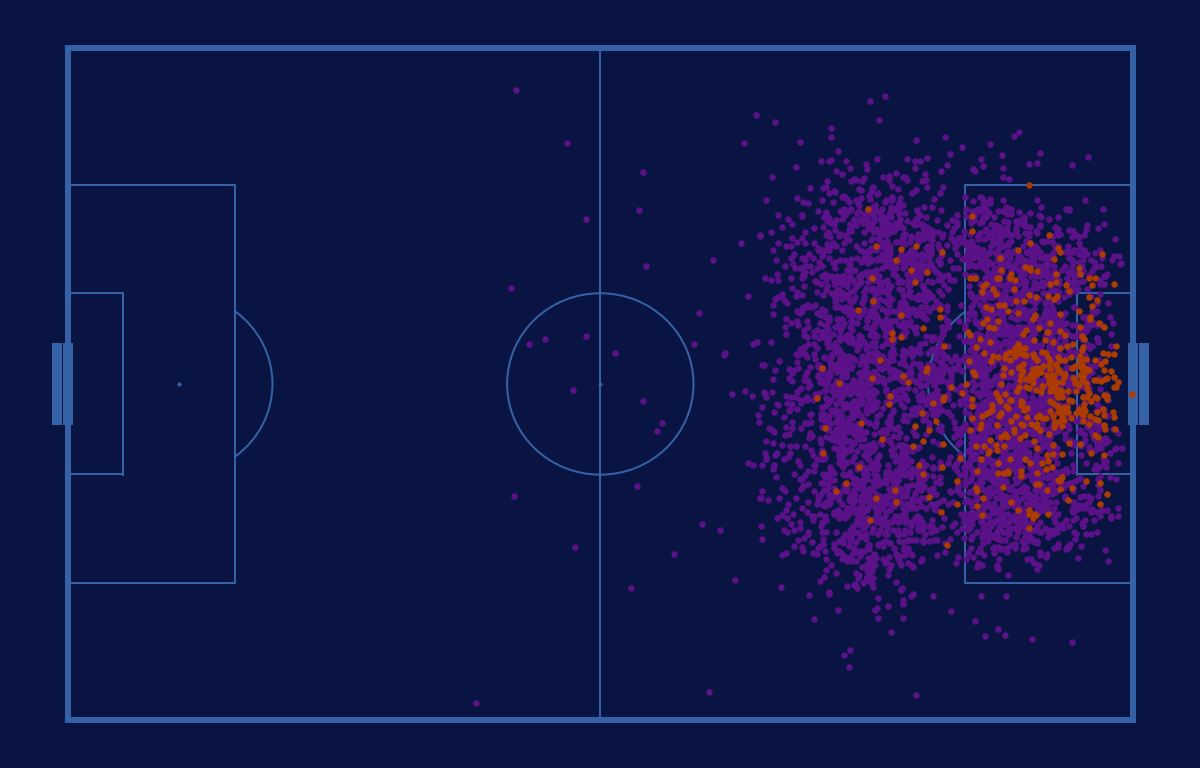

In [6]:
draw.pitch()
all_shots = []
all_goals = []
for game in all_games:
    for event in game['events']:
        suitable = True
        if 'isShot' in event.keys():
            for qualifier in event['qualifiers']:
                if qualifier['type']['displayName'] in ['Penalty', 'SetPiece', 'FreekickTaken', 'DirectFreekick', 'FromCorner']:
                    suitable = False
            if suitable:
                if 'isShot' in event.keys() and 'isGoal' not in event.keys():
                    all_shots.append([event['x'], event['y']])
                if 'isGoal' in event.keys() and 'isOwnGoal' not in event.keys():
                    all_goals.append([event['x'], event['y']])
plt.scatter(*zip(*all_shots), s=5, color = '#5b1289', zorder = 5);
plt.scatter(*zip(*all_goals), s=5, color = '#ab3b00', zorder = 5);

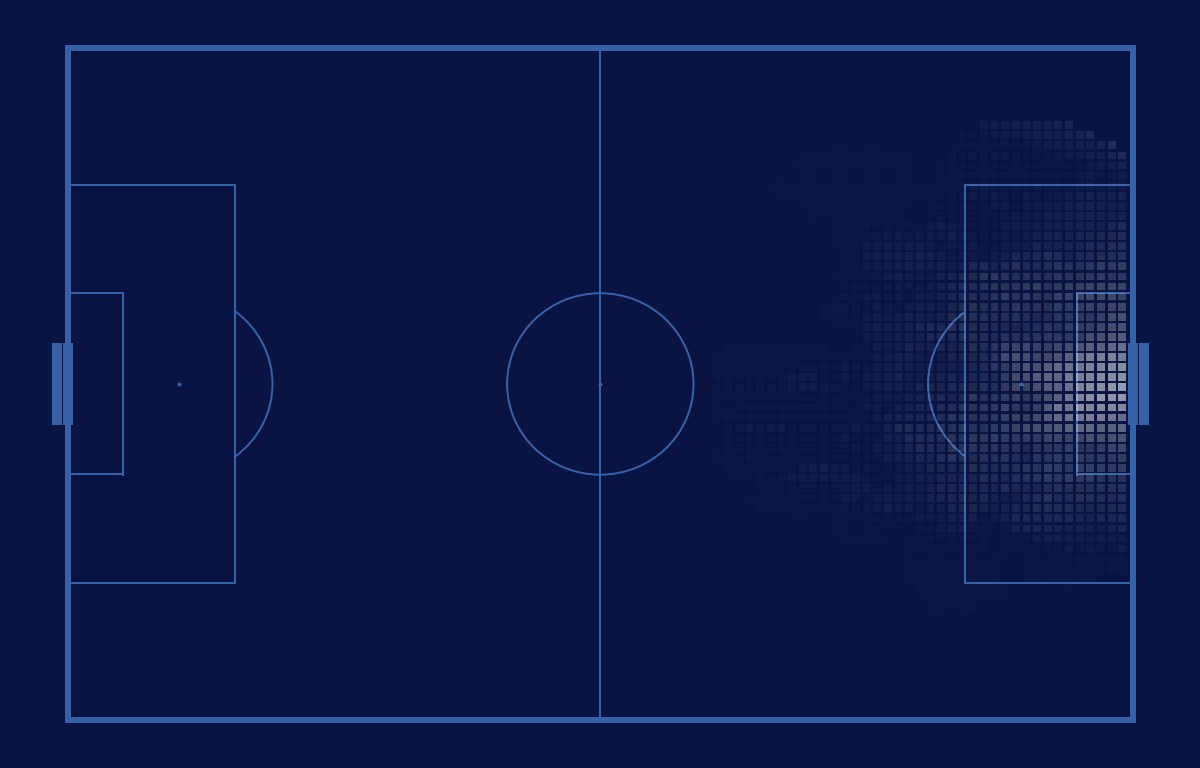

In [35]:
xgmap = calculate_xg_map(all_shots, all_goals, k = 100)
plot_xg_map(xgmap)

In [7]:
data = [i + [0] for i in all_shots] + [i + [1] for i in all_goals]
data = pd.DataFrame(data, columns=['x','y','isGoal'])

xgmap = [[i,j] for i in range(50,100) for j in np.arange(0, 100, 1.5)]
xgmap = pd.DataFrame(xgmap, columns=['x','y'])

In [8]:
data

,x,y,isGoal
0,72.5,46.0,0
1,91.0,50.3,0
2,84.2,36.5,0
3,75.8,55.5,0
4,71.2,64.0,0
...,...,...,...
4946,97.3,48.4,1
4947,91.4,48.8,1
4948,84.7,43.1,1
4949,91.0,45.1,1


def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []

    in_features = 2
    for i in range(n_layers):
        out_features = trial.suggest_int('n_units_l{}'.format(i), 4, 128)
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.Tanh())
        in_features = out_features
    layers.append(torch.nn.Linear(in_features, 2))
    layers.append(torch.nn.Softmax(dim=1))
    model = torch.nn.Sequential(*layers).to(torch.device('cpu'))

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in tqdm(range(100)):

        optimizer.zero_grad()

        outputs = model(torch.tensor(data[['x', 'y']].values.astype(np.float32)))
        loss = criterion(outputs, torch.tensor(data['isGoal'].values))
        loss.backward()
        optimizer.step()

    return loss.item()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
study.best_params

In [9]:
layers = []
layers.append(torch.nn.Linear(2, 64))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(64, 32))
layers.append(torch.nn.ReLU())
layers.append(torch.nn.Linear(32, 2))
layers.append(torch.nn.LogSoftmax(dim=1))

model = torch.nn.Sequential(*layers).to(torch.device('cpu'))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


for epoch in tqdm(range(500)):
    optimizer.zero_grad()
    outputs = model(torch.tensor(data[['x', 'y']].values.astype(np.float32)))
    loss = criterion(outputs, torch.tensor(data['isGoal'].values))
    loss.backward()
    optimizer.step()

sm = torch.nn.Softmax(dim=1)
xgmap['xg'] = sm(model(torch.tensor(xgmap[['x', 'y']].values.astype(np.float32))).detach()).numpy()[:,1]

100%|██████████| 500/500 [00:04<00:00, 103.22it/s]


In [10]:
sm(model(torch.tensor(xgmap[['x', 'y']].values.astype(np.float32))).detach())

tensor([[0.9692, 0.0308],
        [0.9662, 0.0338],
        [0.9630, 0.0370],
        ...,
        [0.9981, 0.0019],
        [0.9986, 0.0014],
        [0.9989, 0.0011]])

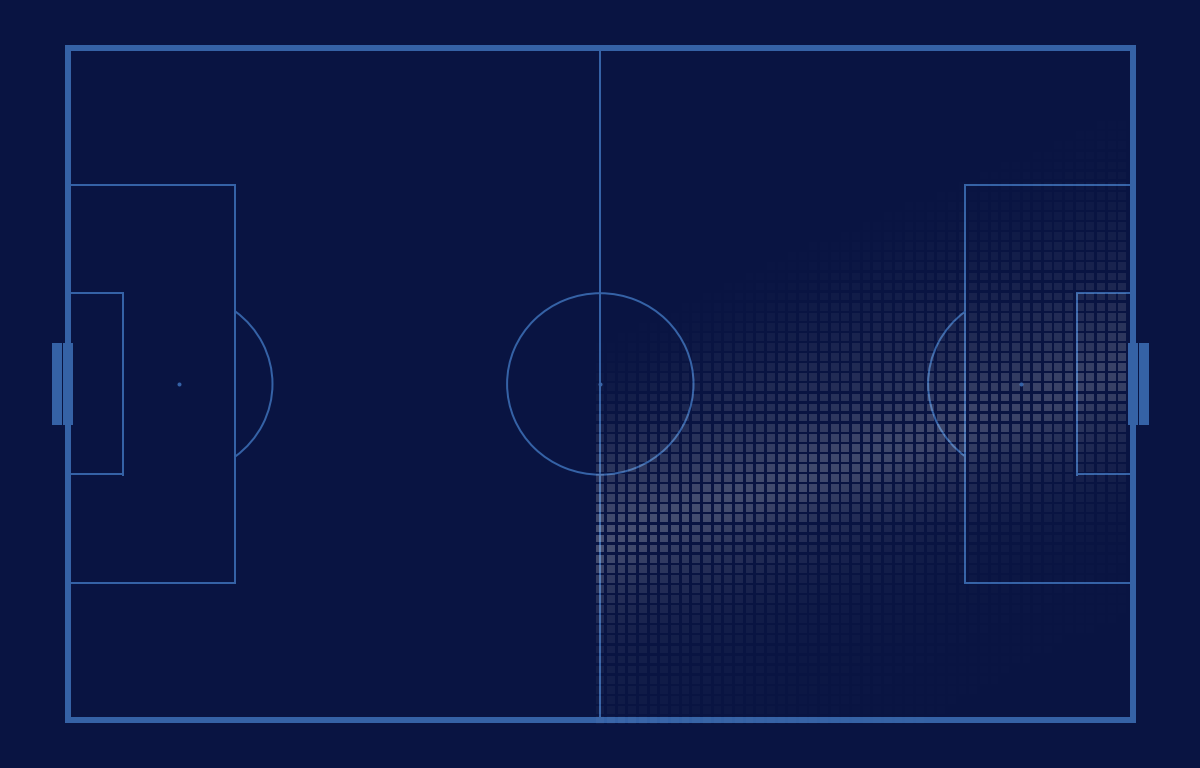

In [11]:
plot_xg_map(xgmap)

In [12]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(data[['x', 'y']], data['isGoal'])

xgmap['xg'] = clf.predict_proba(xgmap[['x', 'y']])[:,1]

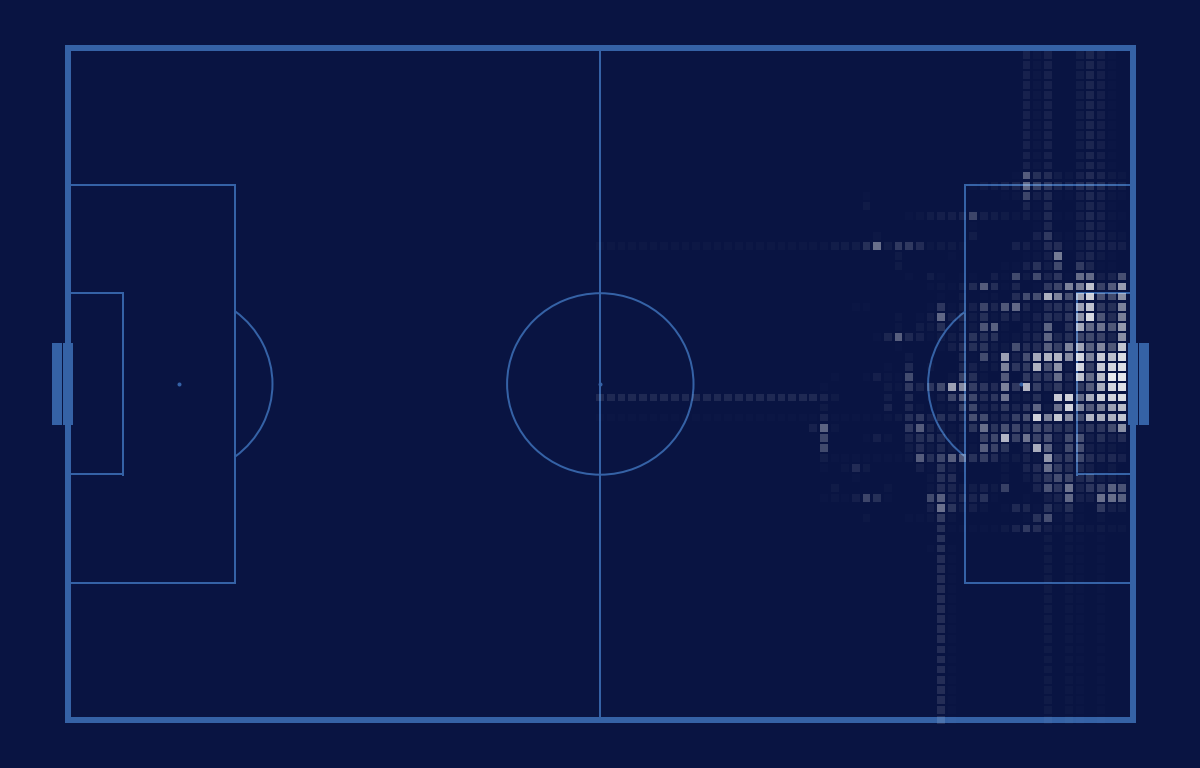

In [13]:
plot_xg_map(xgmap)

In [14]:
clf = MLPClassifier(hidden_layer_sizes=[64,64,64], activation='tanh', learning_rate_init=0.001, max_iter=500)
clf.fit(data[['x', 'y']], data['isGoal'])

xgmap['xg'] = clf.predict_proba(xgmap[['x', 'y']])[:,1]

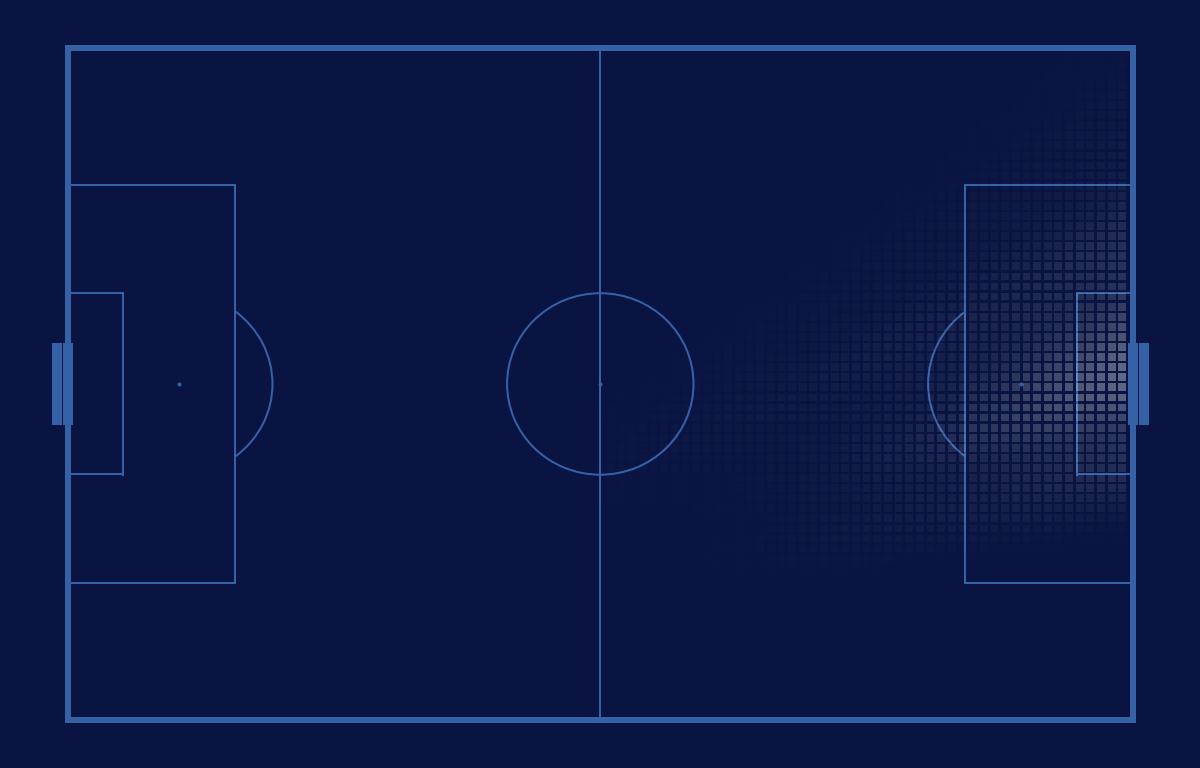

In [15]:
plot_xg_map(xgmap)

In [22]:
from sklearn.metrics import mean_squared_error

def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('n_units_l{}'.format(i), 4, 128))

    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    lr = trial.suggest_float('learning_rate', 0.00001, 0.05)
    lr_type = trial.suggest_categorical('learning_rate_type', ['constant', 'invscaling', 'adaptive'])
    max_iterations = trial.suggest_int('epochs', 20, 750)
    early_stop = trial.suggest_categorical('early_stop', [False, True])
    
    clf = MLPClassifier(hidden_layer_sizes=layers, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iterations, early_stopping=early_stop)
    clf.fit(data[['x', 'y']], data['isGoal'])

    pred = clf.predict_proba(data[['x', 'y']])[:,1]

    return mean_squared_error(pred, data['isGoal'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
study.best_params

ts_l1': 39, 'n_units_l2': 19, 'n_units_l3': 128, 'n_units_l4': 27, 'activation': 'identity', 'learning_rate': 0.04690928510849983, 'learning_rate_type': 'constant', 'epochs': 120, 'early_stop': False}. Best is trial 38 with value: 0.0788609270454598.
[I 2020-10-27 15:26:20,562] Trial 48 finished with value: 0.08486316729347686 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'n_units_l1': 26, 'activation': 'tanh', 'learning_rate': 0.04739077934000232, 'learning_rate_type': 'constant', 'epochs': 99, 'early_stop': False}. Best is trial 38 with value: 0.0788609270454598.
[I 2020-10-27 15:26:29,309] Trial 49 finished with value: 0.0790932638318177 and parameters: {'n_layers': 5, 'n_units_l0': 97, 'n_units_l1': 49, 'n_units_l2': 17, 'n_units_l3': 128, 'n_units_l4': 30, 'activation': 'identity', 'learning_rate': 0.04429717129497064, 'learning_rate_type': 'constant', 'epochs': 109, 'early_stop': False}. Best is trial 38 with value: 0.0788609270454598.
[I 2020-10-27 15:26:31,861] Trial 50 fi

{'n_layers': 5,
 'n_units_l0': 93,
 'n_units_l1': 21,
 'n_units_l2': 23,
 'n_units_l3': 128,
 'n_units_l4': 54,
 'activation': 'identity',
 'learning_rate': 0.04846757162395869,
 'learning_rate_type': 'constant',
 'epochs': 193,
 'early_stop': False}

In [33]:
clf = MLPClassifier(hidden_layer_sizes=[93,21,23,128,54], activation='tanh', learning_rate='constant', learning_rate_init=0.0001, max_iter=193)
clf.fit(data[['x', 'y']], data['isGoal'])

xgmap['xg'] = clf.predict_proba(xgmap[['x', 'y']])[:,1]

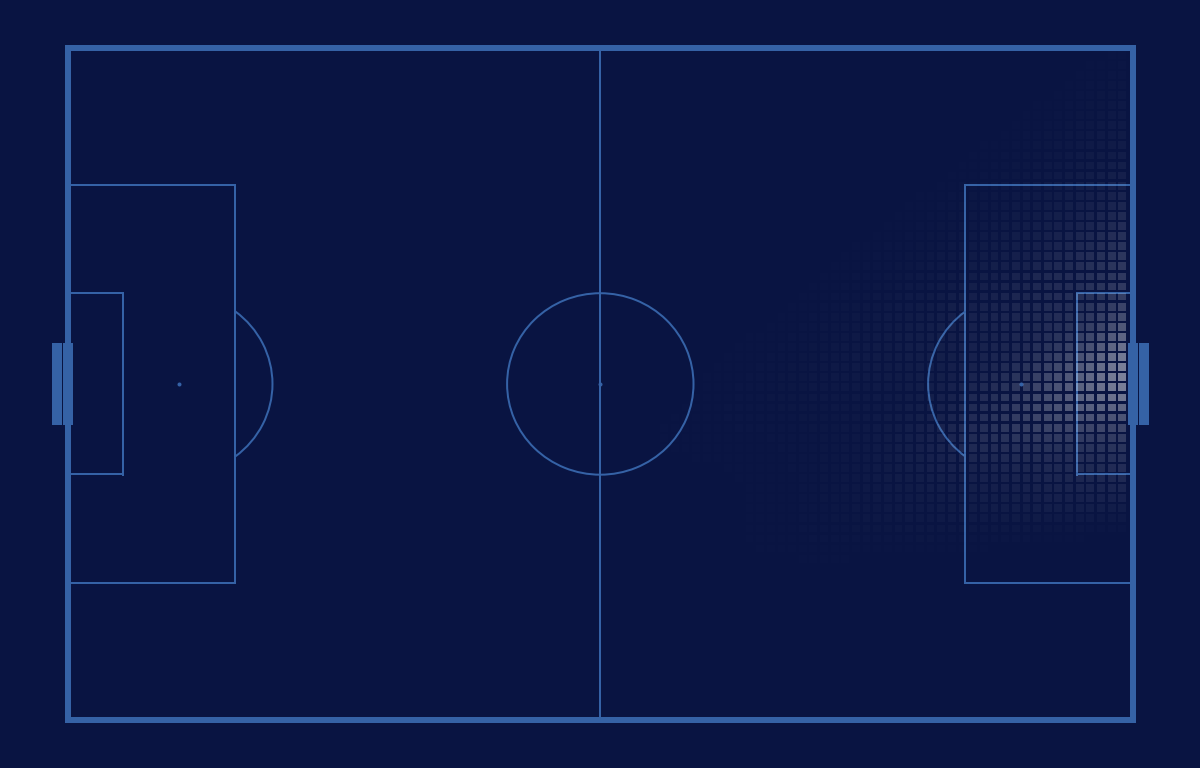

In [34]:
plot_xg_map(xgmap)